In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.utils import shuffle 
from sklearn.base import BaseEstimator, ClassifierMixin, clone  
import copy 
import time 
from joblib import Parallel, delayed  
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.validation import check_is_fitted 
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import normalize 
from sklearn.metrics import average_precision_score 
import plotly.graph_objects as go 
import tempfile  
from scipy.stats import mode 
from itertools import product  
from sklearn.base import BaseEstimator, ClassifierMixin  
from sklearn.base import clone

from randomboosting import RandomBoosting
from randomboosting import MyModel  
from tests import TestRandomBoosting 
import unittest
from sklearn.feature_selection import RFE

In [2]:
#install datasets 
#https://disk.yandex.ru/i/bxFFIhEMUiFZeQ

# Подготовка Данных

In [3]:
def addFeatures(df): 
    df_ = pd.DataFrame()
    df_['TIM_abs_eta_jet1'] = np.abs(df.PRI_jet_leading_eta)   
    df_['TIM_abs_eta_jet2'] = np.abs(df.PRI_jet_subleading_eta)       
    df_['TIM_deltaeta_tau_lep'] = np.abs(df.PRI_tau_eta-df.PRI_lep_eta)
    df_['TIM_deltaeta_tau_jet1'] = np.abs(df.PRI_tau_eta-df.PRI_jet_leading_eta)
    df_['TIM_deltaeta_tau_jet2'] = np.abs(df.PRI_tau_eta-df.PRI_jet_subleading_eta)
    df_['TIM_deltaeta_lep_jet1'] = np.abs(df.PRI_lep_eta-df.PRI_jet_leading_eta)
    df_['TIM_deltaeta_lep_jet2'] = np.abs(df.PRI_lep_eta-df.PRI_jet_subleading_eta)
    df_['TIM_deltaeta_jet_jet'] = np.abs(df.PRI_jet_leading_eta-df.PRI_jet_subleading_eta)

    df_['TIM_prodeta_tau_lep'] = df.PRI_tau_eta*df.PRI_lep_eta
    df_['TIM_prodeta_tau_jet1'] = df.PRI_tau_eta*df.PRI_jet_leading_eta
    df_['TIM_prodeta_tau_jet2'] = df.PRI_tau_eta*df.PRI_jet_subleading_eta
    df_['TIM_prodeta_lep_jet1'] = df.PRI_lep_eta*df.PRI_jet_leading_eta
    df_['TIM_prodeta_lep_jet2'] = df.PRI_lep_eta*df.PRI_jet_subleading_eta
    df_['TIM_prodeta_jet_jet'] = df.PRI_jet_leading_eta*df.PRI_jet_subleading_eta
    d = df.PRI_tau_phi - df.PRI_lep_phi
    d = 1.0 - 2.0*((d>np.pi)|((d<0) & (d>-np.pi)))
    a = np.sin(df.PRI_met_phi-df.PRI_lep_phi)
    b = np.sin(df.PRI_tau_phi-df.PRI_met_phi)
    df_['TIM_met_phi_centrality'] = d*(a+b)/np.sqrt(np.square(a)+np.square(b))
    df_['TIM_lep_eta_centrality'] = np.exp(-4.0*np.square(df.PRI_lep_eta-(df.PRI_jet_leading_eta+df.PRI_jet_subleading_eta)/2)/np.square(df.PRI_jet_leading_eta-df.PRI_jet_subleading_eta))
    df_['TIM_tau_eta_centrality'] = np.exp(-4.0*np.square(df.PRI_tau_eta-(df.PRI_jet_leading_eta+df.PRI_jet_subleading_eta)/2)/np.square(df.PRI_jet_leading_eta-df.PRI_jet_subleading_eta))   
    df_['TIM_pt_ratio_lep_tau'] = df.PRI_lep_pt/df.PRI_tau_pt
    df_['Label'] = df['Label']
    return df_


df_higgs_train = pd.read_csv('Higgs_train.csv') 
df_higgs_train=addFeatures(df_higgs_train)
#df_higgs_train = df_higgs_train.drop(['EventId'], axis=1)
df_higgs_train['Label'] =df_higgs_train['Label'].map({'s':0,'b':1})  

df_higgs_0 = df_higgs_train[df_higgs_train['Label'] == 0].sample(85667, random_state=42)
df_higgs_1 = df_higgs_train[df_higgs_train['Label'] == 1].sample(85667, random_state=42) 

df_higgs_balanced = pd.concat([df_higgs_0, df_higgs_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_higgs ,X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(df_higgs_balanced.drop(['Label'], axis=1), 
                                                    df_higgs_balanced['Label']   , test_size=0.2, random_state=43) 

In [4]:
df_higgs_balanced_ = df_higgs_balanced[['TIM_pt_ratio_lep_tau', 'TIM_met_phi_centrality', 'TIM_deltaeta_tau_lep', 
                                       'TIM_prodeta_tau_lep', 'TIM_deltaeta_lep_jet1', 'TIM_deltaeta_tau_jet1', 
                                       'TIM_deltaeta_lep_jet2', 'TIM_prodeta_lep_jet2', 'TIM_prodeta_lep_jet1', 'Label']] 

X_train_higgs, X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(
    df_higgs_balanced_.drop(['Label'], axis=1), 
    df_higgs_balanced_['Label'], 
    test_size=0.2, 
    random_state=69
)

# Сравнение с RandomForestClassifier

In [5]:
rf_model = RandomForestClassifier(n_estimators = 30, max_depth = 3, max_features = 1., bootstrap=False,  random_state=69)
rf_model.fit(X_train_higgs, y_train_higgs)
print('rf_accuracy: ', accuracy_score(y_test_higgs, rf_model.predict(X_test_higgs)) ) 



rb = RandomBoosting(n_estimators=1,  max_depth = 3, n_models = 30, model_features = 1.,  max_features = 1. , n_jobs= 30, random_state = 69)
rb.fit(X_train_higgs, y_train_higgs)
print('accuracy rb: ', accuracy_score( y_test_higgs, rb.predict(X_test_higgs)) )

rf_accuracy:  0.6897598272390346
accuracy rb:  0.6897598272390346


# Сравнение с GradientBoostingClassifier

In [6]:
gb_model = GradientBoostingClassifier(n_estimators = 30, max_depth = 3, max_features = 1.,  random_state=69)
gb_model.fit(X_train_higgs, y_train_higgs)
print('gb_accuracy: ', accuracy_score(y_test_higgs, gb_model.predict(X_test_higgs)) ) 



rb = RandomBoosting(n_estimators=30,  max_depth = 3, n_models = 1, model_features = 1.,  max_features = 1. ,random_state = 69)
rb.fit(X_train_higgs, y_train_higgs)
print('accuracy rb: ', accuracy_score( y_test_higgs, rb.predict(X_test_higgs)) )

gb_accuracy:  0.7032713689555549
accuracy rb:  0.7032713689555549


# Warm_start

In [7]:
start_time = time.time()
rb = RandomBoosting(n_estimators=1, learning_rate = 0.15, max_depth = 3, n_models = 1,  
                    model_features = 3, n_jobs= 30, random_state = 69)
rb.fit(X_train_higgs, y_train_higgs)
end_time = time.time()
elapsed_time = end_time - start_time  
print(f"Время выполнения fit с n_estimators=19: {elapsed_time:.2f} секунд") 
print('accuracy_gbfp: ', accuracy_score( y_test_higgs, rb.predict(X_test_higgs)) )
print('n_estimators: ', rb.modelsTrast[0].model.n_estimators) 
print('n_models: ', len(rb.modelsTrast)) 
#print([rb.modelsTrast[i].selected_features for i in range(len(rb.modelsTrast))] )

print('\n')
start_time = time.time()
rb.set_params(n_estimators=20, n_models = 10)
rb.fit(X_train_higgs, y_train_higgs) 
end_time = time.time()
elapsed_time = end_time - start_time  
print(f"Время выполнения fit с n_estimators=20: {elapsed_time:.2f} секунд")
print('accuracy_gbfp: ', accuracy_score( y_test_higgs, rb.predict(X_test_higgs)) )
print('n_estimators: ', rb.modelsTrast[0].model.n_estimators) 
print('n_models: ', len(rb.modelsTrast)) 
#print([rb.modelsTrast[i].selected_features for i in range(len(rb.modelsTrast))] ) 

Время выполнения fit с n_estimators=19: 0.65 секунд
accuracy_gbfp:  0.6469489596404704
n_estimators:  1
n_models:  1


Время выполнения fit с n_estimators=20: 3.79 секунд
accuracy_gbfp:  0.6482913590334725
n_estimators:  20
n_models:  1


# Вырождение модели в случай одного дерева и сравнение с RandomForestClassifier и DecisionTreeClassifier

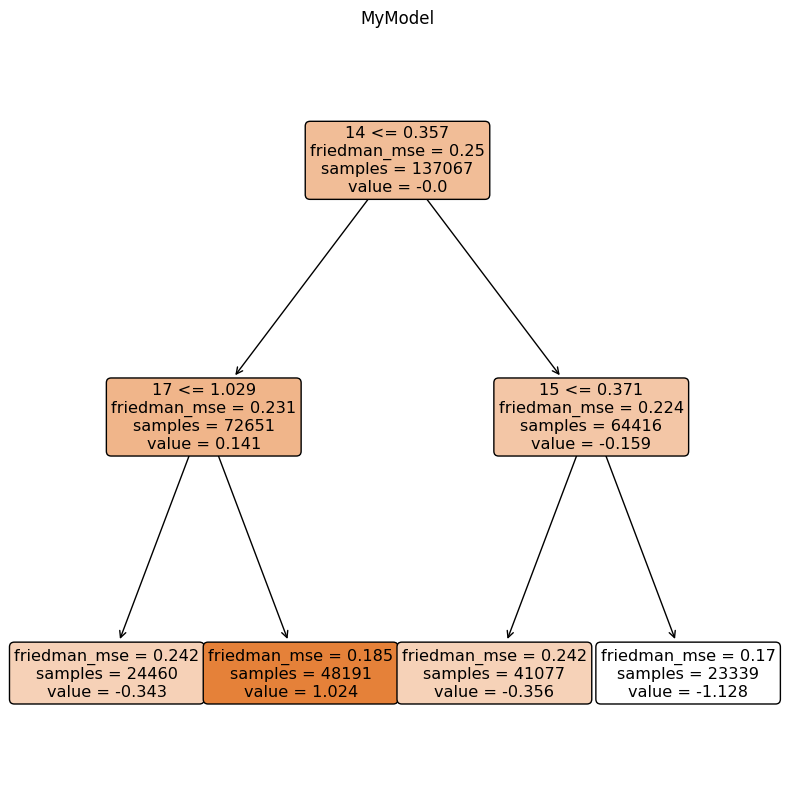

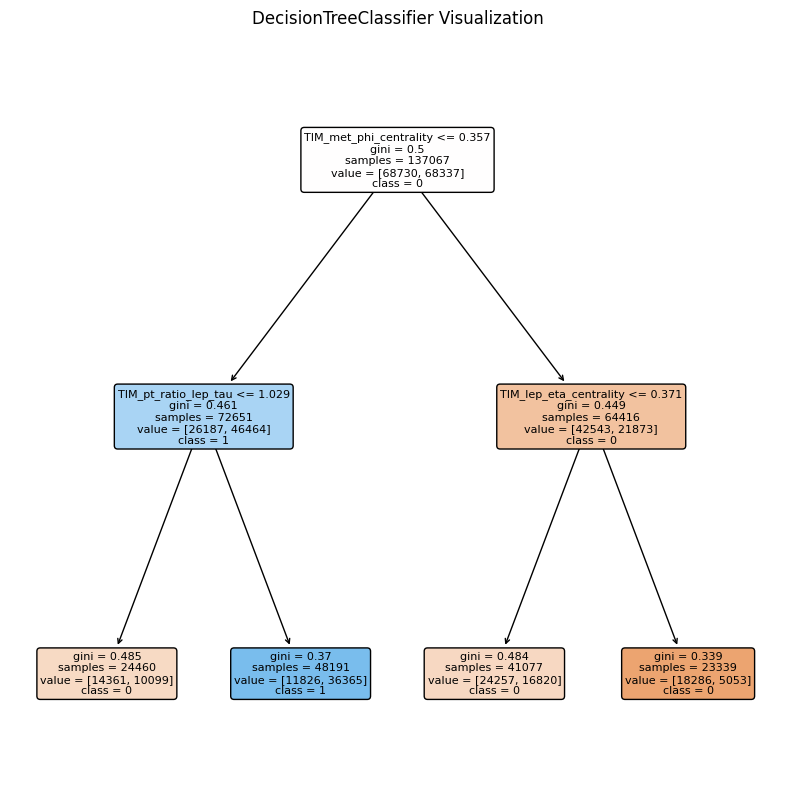

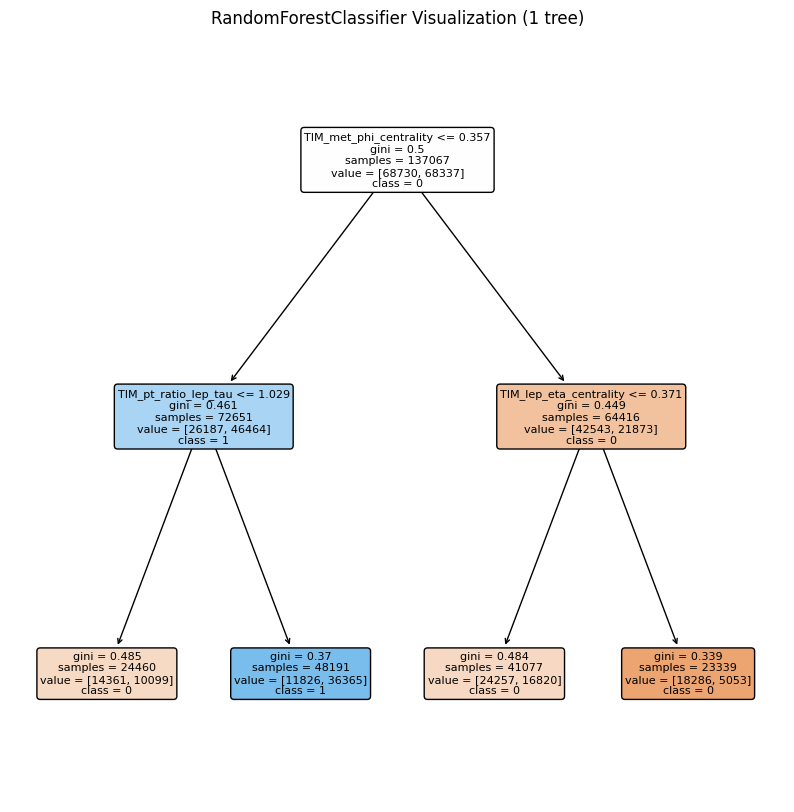

In [45]:
X_train_higgs ,X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(df_higgs_balanced.drop(['Label'], axis=1), 
                                                    df_higgs_balanced['Label']   , test_size=0.2, random_state=43) 

plt.figure(figsize=(10,10))
gbfp_ = RandomBoosting(n_estimators=1, learning_rate=0.1, max_depth=2, n_models = 1, 
                       model_features = 18,  n_jobs= 30, random_state = 69,  voting_weights =  0) 
gbfp_.fit(X_train_higgs, y_train_higgs)
selected_tree = gbfp_.modelsTrast[0].model[0, 0]
plot_tree(selected_tree, filled=True, feature_names=gbfp_.modelsTrast[0].selected_features, class_names=np.unique(y_train_higgs).astype(str), rounded=True) 
plt.title("MyModel")
plt.show()  


plt.figure(figsize=(10,10))
tree_clf = DecisionTreeClassifier(max_depth=2, max_features = 18, random_state=69) 
tree_clf.fit(X_train_higgs, y_train_higgs)
#tree_clf.fit(X_train_higgs.sample(frac=1, replace=True, random_state = 60), y_train_higgs.sample(frac=1, replace=True, random_state = 60))
plot_tree(tree_clf, filled=True, feature_names=X_train_higgs.columns, class_names= np.unique(y_train_higgs).astype(str), rounded=True) 
plt.title("DecisionTreeClassifier Visualization")
plt.show()   

plt.figure(figsize=(10,10))
rf = RandomForestClassifier(n_estimators = 1, max_depth=2, max_features = 18, bootstrap=False,  random_state=69)
rf.fit(X_train_higgs, y_train_higgs)
y_pred_higgs = rf.predict(X_test_higgs)
plot_tree(rf.estimators_[0], filled=True, feature_names=X_train_higgs.columns, class_names=np.unique(y_train_higgs).astype(str), rounded=True)
plt.title("RandomForestClassifier Visualization (1 tree)") 
plt.show()

# GridSearchCV

In [46]:
# Подготовка данных
df_higgs_balanced = df_higgs_balanced[['TIM_pt_ratio_lep_tau', 'TIM_met_phi_centrality', 'TIM_deltaeta_tau_lep', 
                                       'TIM_prodeta_tau_lep', 'TIM_deltaeta_lep_jet1', 'TIM_deltaeta_tau_jet1', 
                                       'TIM_deltaeta_lep_jet2', 'TIM_prodeta_lep_jet2', 'TIM_prodeta_lep_jet1', 'Label']]

X_train_higgs, X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(
    df_higgs_balanced.drop(['Label'], axis=1), 
    df_higgs_balanced['Label'], 
    test_size=0.2, 
    random_state=69
)
X_train, X_test, y_train, y_test = X_train_higgs, X_test_higgs, y_train_higgs, y_test_higgs
rb = RandomBoosting(random_state=69)
param_grid = {
    'n_estimators': [3],
    'learning_rate': [0.15],
    'max_depth': [14],
    'subsample': [1], 
    'n_models': [30],
    'model_features': [1,2,5,7,9], 
    'max_features': [3],
    'random_state': [69],
    'n_jobs': [30]
}
start_time = time.time()
grid_search = GridSearchCV(estimator=rb, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train) 
end_time = time.time()
elapsed_time = end_time - start_time 
print(f"Время выполнения GridSearchCV: {elapsed_time:.2f} секунд") 

print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Точность на тестовой выборке:", accuracy_score(y_test, y_pred))

Время выполнения GridSearchCV: 98.09 секунд
Лучшие параметры: {'learning_rate': 0.15, 'max_depth': 14, 'max_features': 3, 'model_features': 9, 'n_estimators': 3, 'n_jobs': 30, 'n_models': 30, 'random_state': 69, 'subsample': 1}
Точность на тестовой выборке: 0.7142440248635714


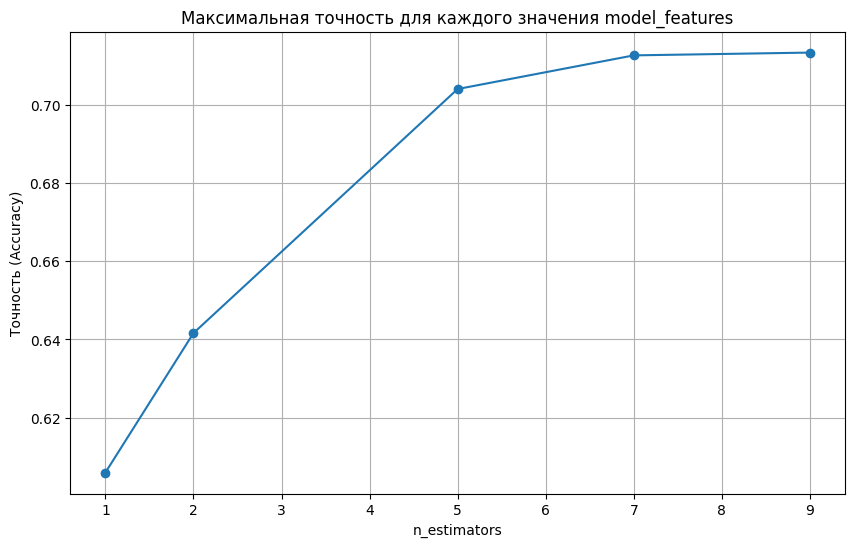

In [47]:
cv_results = grid_search.cv_results_

# Преобразуем результаты в DataFrame для удобства
results_df = pd.DataFrame(cv_results)

# Группировка по max_features и нахождение максимального значения accuracy
max_accuracy_per_max_features = results_df.groupby('param_model_features')['mean_test_score'].max()

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(max_accuracy_per_max_features.index, max_accuracy_per_max_features.values, marker='o')
plt.title('Максимальная точность для каждого значения model_features')
plt.xlabel('n_estimators')
plt.ylabel('Точность (Accuracy)')
plt.grid(True)
plt.show()

# Поведение модели при фиксированной сложности вычислений в количестве дервьев

In [290]:
# Подготовка данных
df_higgs_balanced = df_higgs_balanced[['TIM_pt_ratio_lep_tau', 'TIM_met_phi_centrality', 'TIM_deltaeta_tau_lep', 
                                       'TIM_prodeta_tau_lep', 'TIM_deltaeta_lep_jet1', 'TIM_deltaeta_tau_jet1', 
                                       'TIM_deltaeta_lep_jet2', 'TIM_prodeta_lep_jet2', 'TIM_prodeta_lep_jet1', 'Label']]

X_train_higgs, X_test_higgs, y_train_higgs, y_test_higgs = train_test_split(
    df_higgs_balanced.drop(['Label'], axis=1), 
    df_higgs_balanced['Label'], 
    test_size=0.2, 
    random_state=69
)

param_grid = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 10, 15, 20, 30, 60],
    'learning_rate': [0.15],
    'max_depth': [14],
    'subsample': [1],
    'model_features': [1,2,3,4,5,6,7,8,9], 
    'max_features': [2, 3, 4, 5],
    'bootstrap': [1],
    'random_state': [69],
    'n_jobs': [30]
}

N = 60
iter_ = 0
param_combinations = list(product(*param_grid.values()))  # Все возможные комбинации параметров
results = []

for params in param_combinations:
    iter_ += 1
    if iter_ % 10 == 0:
        print(f"Прогресс: {round((iter_ / len(param_combinations)) * 100, 2)}%")
    
    params_dict = dict(zip(param_grid.keys(), params))
    n_estimators_value = params_dict['n_estimators']
    params_dict['n_models'] = N // n_estimators_value   
    
    gbfp_ = RandomBoosting( 
        n_estimators=params_dict['n_estimators'],
        learning_rate=params_dict['learning_rate'],
        max_depth=params_dict['max_depth'],
        subsample=params_dict['subsample'],
        max_features=params_dict['max_features'],
        random_state=params_dict['random_state'], 
        n_models=params_dict['n_models'],
        model_features=params_dict['model_features'],
        bootstrap=params_dict['bootstrap'],
        n_jobs=params_dict['n_jobs']
    )
    gbfp_.fit(X_train_higgs, y_train_higgs)
    y_pred_gbfp = gbfp_.predict(X_test_higgs)
    accuracy_gbfp = accuracy_score(y_test_higgs, y_pred_gbfp)
    accuracy_train = accuracy_score(y_train_higgs, gbfp_.predict(X_train_higgs))
    feature_importances = gbfp_.feature_importances_
    results.append({
        **params_dict, 
        'accuracy_test': accuracy_gbfp, 
        'accuracy_train': accuracy_train, 
        'MeanVar': gbfp_.mean_variance
    })
df_results = pd.DataFrame(results)

Прогресс: 2.53%
Прогресс: 5.05%
Прогресс: 7.58%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 10.1%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 12.63%
Прогресс: 15.15%
Прогресс: 17.68%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 20.2%
Прогресс: 22.73%
Прогресс: 25.25%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 27.78%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 30.3%
Прогресс: 32.83%
Прогресс: 35.35%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 37.88%
Прогресс: 40.4%
Прогресс: 42.93%
Прогресс: 45.45%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 47.98%
Прогресс: 50.51%
Прогресс: 53.03%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 55.56%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 58.08%
Прогресс: 60.61%
Прогресс: 63.13%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 65.66%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 68.18%
Прогресс: 70.71%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 73.23%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipy

Прогресс: 75.76%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 78.28%
Прогресс: 80.81%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 83.33%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipy

Прогресс: 85.86%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 90.91%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 93.43%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


Прогресс: 95.96%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipy

Прогресс: 98.48%


/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)
/tmp/ipykernel_1013486/574369888.py:221: RuntimeWarning: Mean of empty slice
  means = np.nanmean(importances_list, axis=0)


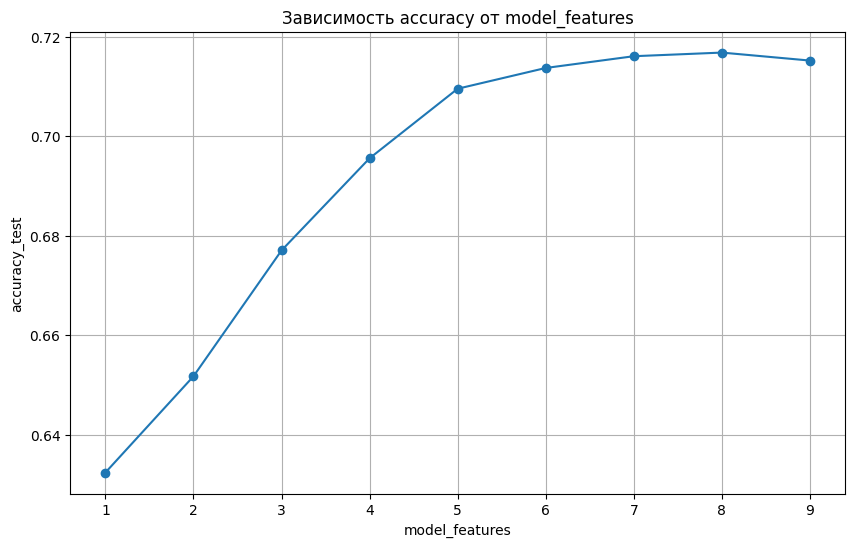

In [291]:
myFeatures = 'model_features'
best_results_df = df_results.groupby(myFeatures)['accuracy_test'].max().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(best_results_df[myFeatures], best_results_df['accuracy_test'], marker='o')
plt.title('Зависимость accuracy от ' + myFeatures)
plt.xlabel(myFeatures)
plt.ylabel('accuracy_test')
plt.grid(True)
plt.show()

In [292]:
def plot_param_dependency(df, param_x, param_y):
    x_values = []
    y_values = []
    accuracy_values = []
    unique_x_values = df[param_x].unique()
    for x_val in unique_x_values:
        df_filtered = df[df[param_x] == x_val]
        best_row = df_filtered.loc[df_filtered['accuracy_test'].idxmax()]
        x_values.append(x_val)
        y_values.append(best_row[param_y])
        accuracy_values.append(best_row['accuracy_test'])
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title(f'{param_y} vs {param_x} (при максимальной accuracy)')
    plt.grid(True)
    plt.show()

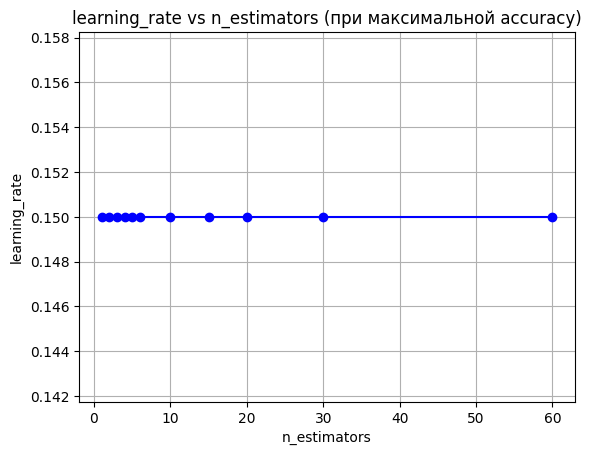

In [293]:
plot_param_dependency(df_results, 'n_estimators', 'learning_rate')

In [294]:
def plot_two_params_dependency(df, param_x, param_y1, param_y2):

    x_values = []
    y1_values = []
    y2_values = []
    accuracy_values = []

    unique_x_values = df[param_x].unique()


    for x_val in unique_x_values:
        df_filtered = df[df[param_x] == x_val]
        best_row = df_filtered.loc[df_filtered['accuracy_test'].idxmax()]
        x_values.append(x_val)
        y1_values.append(best_row[param_y1])
        y2_values.append(best_row[param_y2])
        accuracy_values.append(best_row['accuracy_test'])

    plt.figure(figsize=(10, 6))
    
    plt.plot(x_values, y1_values, marker='o', linestyle='-', color='b', label=param_y1)
    plt.plot(x_values, y2_values, marker='o', linestyle='--', color='r', label=param_y2)
    
    plt.xlabel(param_x)
    plt.ylabel('Значения параметров')
    plt.title(f'{param_y1} и {param_y2} vs {param_x} (при максимальной accuracy)')
    
    plt.legend()  
    plt.grid(True)
    plt.show()

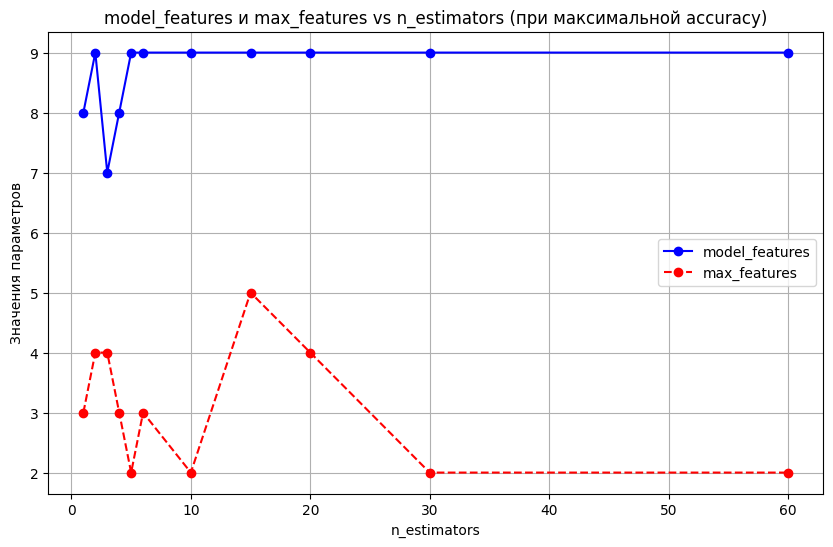

In [295]:
plot_two_params_dependency(df_results, 'n_estimators', 'model_features', 'max_features')

# Give me some credits feature importance

In [4]:
UCI_credit = pd.read_csv('UCI_Credit_Card.csv') 
df = UCI_credit.copy() 

In [5]:
def f1(x1, x2, x3): 
    a = x1 
    b = (x2+x3)/2  
    if a == b and a == 0: 
        return 0 
    else:
        return (a - b)/max(abs(a), abs(b)) 

def f2(x1, x2, x3): 
    a = x1 
    b = (x2+x3)/2 
     
    return a - b  


df['new_feature_1'] = df.apply(lambda x: f1(x['BILL_AMT1'], x['BILL_AMT2'],  x['BILL_AMT3'] ), axis = 1) 
df['new_feature_2'] = df.apply(lambda x: f2(x['BILL_AMT1'], x['BILL_AMT2'],  x['BILL_AMT3'] ), axis = 1)   
df['new_feature_1_2_equal_zero'] = df.apply(lambda x: int( x['BILL_AMT1'] == (x['BILL_AMT2'] + x['BILL_AMT3'] )/2 and  x['BILL_AMT1'] == 0 ), axis = 1) 




df_class_1 = df[df['default.payment.next.month'] == 1].sample(5051, random_state=42)
df_class_0 = df[df['default.payment.next.month'] == 0].sample(5051, random_state=42)
df_ = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True).dropna() 
df_ = shuffle(df_, random_state=42).drop(["ID"], axis = 1)


Accuracy of DecisionTree with max_depth=1: 0.5886
Accuracy of DecisionTree with max_depth=2: 0.5886


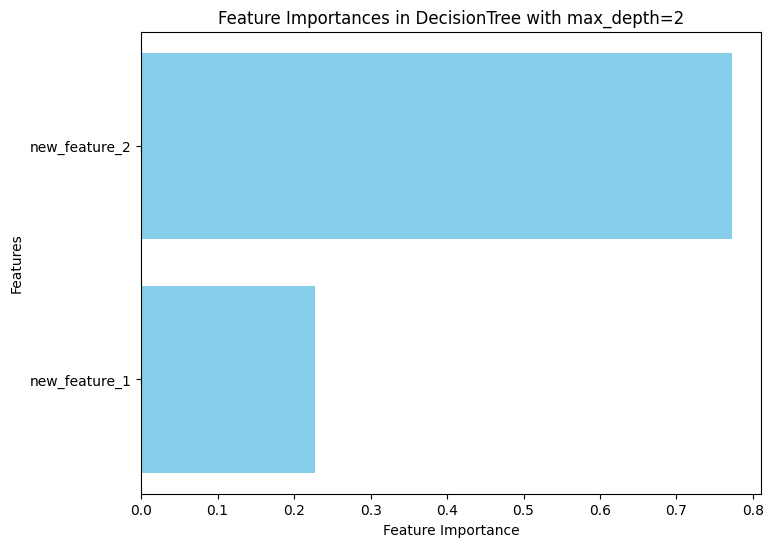

In [6]:
X = df_[['new_feature_1', 'new_feature_2']]
y = df_['default.payment.next.month']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_depth_1 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_depth_1.fit(X_train, y_train)
y_pred_1 = tree_depth_1.predict(X_test)


accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"Accuracy of DecisionTree with max_depth=1: {accuracy_1:.4f}")


tree_depth_2 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_depth_2.fit(X_train, y_train)
y_pred_2 = tree_depth_2.predict(X_test)


accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Accuracy of DecisionTree with max_depth=2: {accuracy_2:.4f}")


importances = tree_depth_2.feature_importances_

plt.figure(figsize=(8, 6))
plt.barh(['new_feature_1', 'new_feature_2'], importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances in DecisionTree with max_depth=2')
plt.show()

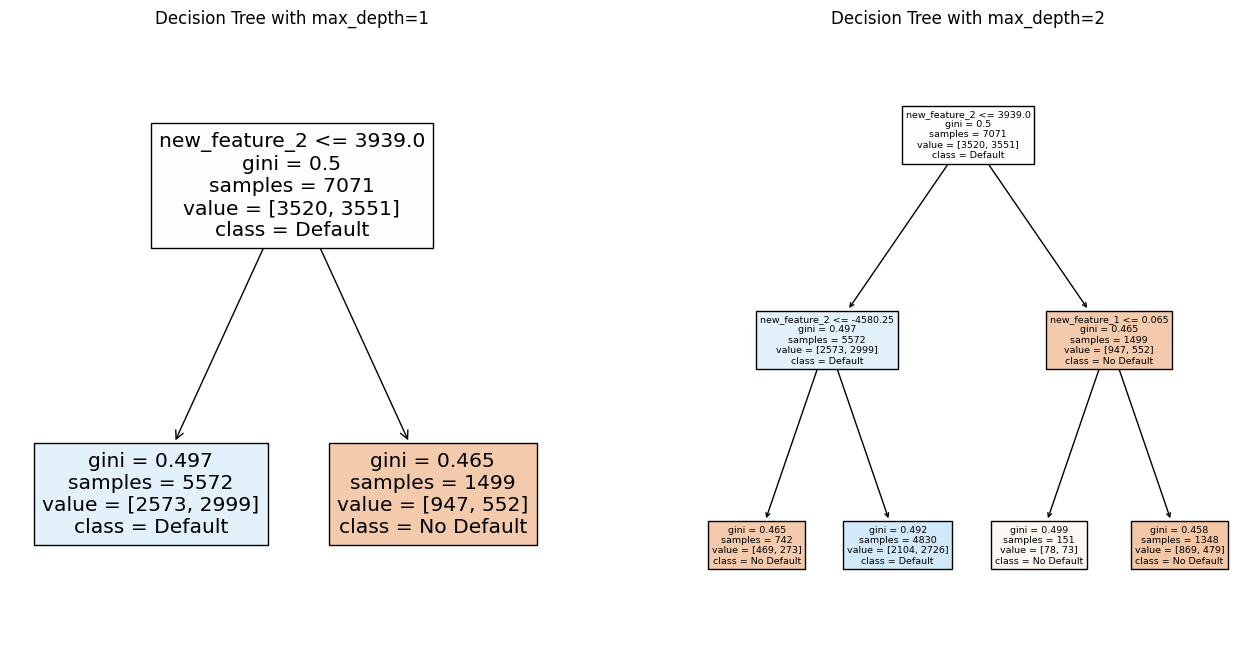

In [7]:
X = df_[['new_feature_1', 'new_feature_2', 'new_feature_1_2_equal_zero']]
y = df_['default.payment.next.month']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_depth_1 = DecisionTreeClassifier(max_depth=1, random_state=42)
tree_depth_1.fit(X_train, y_train)


tree_depth_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_depth_2.fit(X_train, y_train)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plot_tree(tree_depth_1, filled=True, feature_names=['new_feature_1', 'new_feature_2'], class_names=['No Default', 'Default'])
plt.title("Decision Tree with max_depth=1")

plt.subplot(1, 2, 2)
plot_tree(tree_depth_2, filled=True, feature_names=['new_feature_1', 'new_feature_2'], class_names=['No Default', 'Default'])
plt.title("Decision Tree with max_depth=2")

plt.show()

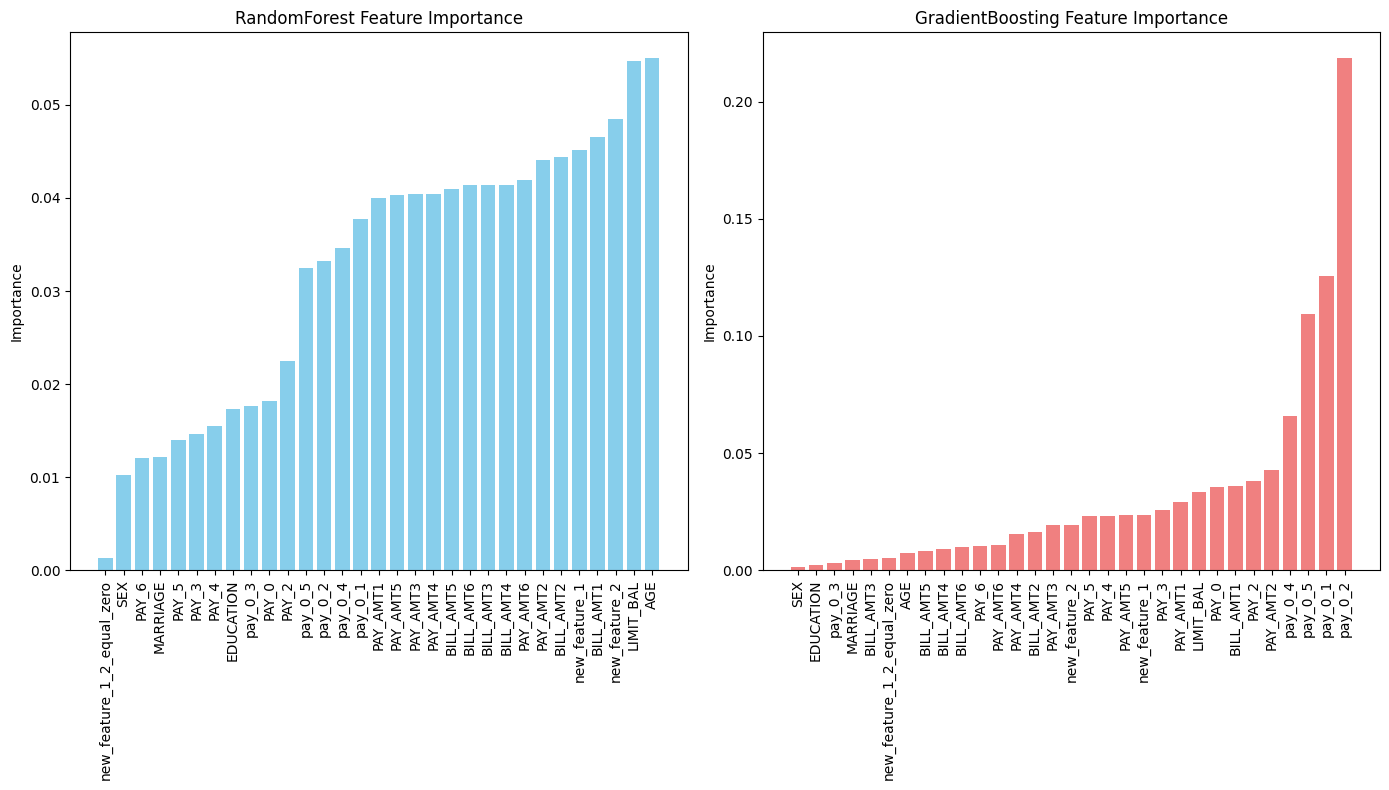

In [8]:
X = df_.drop(columns=['default.payment.next.month'])
y = df_['default.payment.next.month']

X['pay_0_1'] = X.apply(lambda x: x['PAY_0']*3, axis = 1)  
X['pay_0_2'] = X.apply(lambda x: x['PAY_0']/3+50, axis = 1)  
X['pay_0_3'] = X.apply(lambda x: x['PAY_0']*10-100, axis = 1) 
X['pay_0_4'] = X.apply(lambda x: x['pay_0_2'] + x['pay_0_3'], axis = 1) 
X['pay_0_5'] = X.apply(lambda x: x['pay_0_4']**2, axis = 1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RandomForest Importance': rf_importances,
    'GradientBoosting Importance': gb_importances
})

importance_df_rf_sorted = importance_df.sort_values(by='RandomForest Importance', ascending=True)
importance_df_gb_sorted = importance_df.sort_values(by='GradientBoosting Importance', ascending=True)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.bar(importance_df_rf_sorted['Feature'], importance_df_rf_sorted['RandomForest Importance'], color='skyblue')
plt.ylabel('Importance')
plt.title('RandomForest Feature Importance')
plt.xticks(rotation=90)  # Rotate feature names for better visibility

plt.subplot(1, 2, 2)
plt.bar(importance_df_gb_sorted['Feature'], importance_df_gb_sorted['GradientBoosting Importance'], color='lightcoral')
plt.ylabel('Importance')
plt.title('GradientBoosting Feature Importance')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [24]:
X = df_.drop(columns=['default.payment.next.month'])   
X['pay_0_1'] = X.apply(lambda x: x['PAY_0']*3, axis = 1)  
X['pay_0_2'] = X.apply(lambda x: x['PAY_0']/3+50, axis = 1)  
X['pay_0_3'] = X.apply(lambda x: x['PAY_0']*10-100, axis = 1) 
X['pay_0_4'] = X.apply(lambda x: x['pay_0_2'] + x['pay_0_3'], axis = 1) 
X['pay_0_5'] = X.apply(lambda x: x['pay_0_4']**2, axis = 1) 

y = df_['default.payment.next.month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



rb = RandomBoosting( n_estimators=50, learning_rate=0.05, max_depth=6,max_features=20, n_models=60, 
                                                                      subsample=1, model_features=22, random_state=49, n_jobs= 30)
rb.fit(X_train, y_train)
    

features = rb.feature_names_in_
importances = rb.feature_importances_
variances =  rb.feature_importances_var_

stds = np.sqrt(variances)
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]
sorted_stds = stds[sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_stds, capsize=5, align='center', alpha=0.7)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
plt.xlabel('Признаки')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

TypeError: 'NoneType' object is not subscriptable

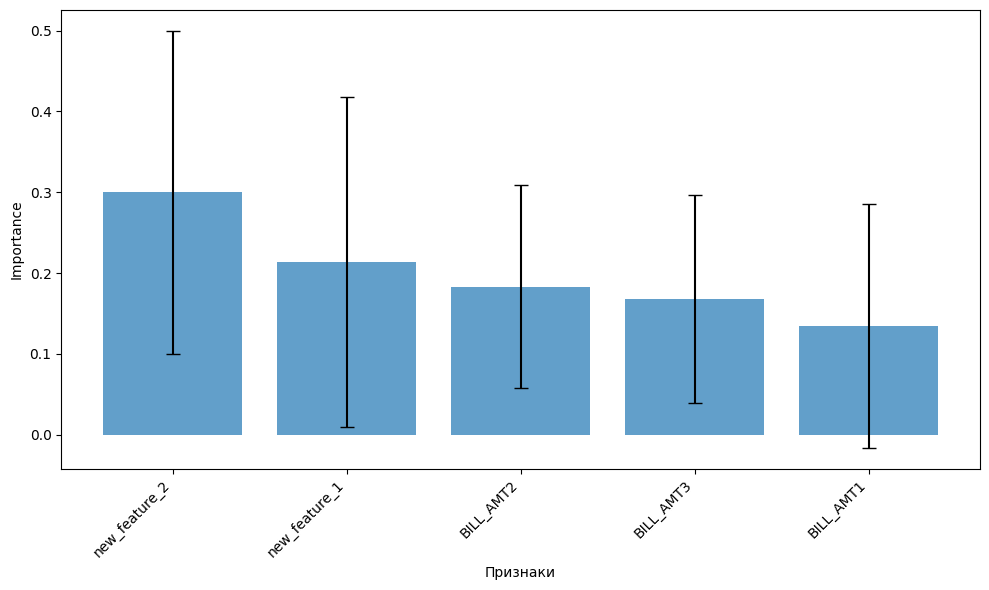

In [10]:
X = df_[['new_feature_1', 'new_feature_2', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']]  
y = df_['default.payment.next.month'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



rb = RandomBoosting( n_estimators=50, learning_rate=0.05, max_depth=6,max_features=1, n_models=60, 
                                                                      subsample=1, model_features=3, random_state=49, n_jobs= 30)
rb.fit(X_train, y_train)
    

features = rb.feature_names_in_
importances = rb.feature_importances_
variances =  rb.feature_importances_var_
stds = np.sqrt(variances) 

sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]
sorted_stds = stds[sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importances, yerr=sorted_stds, capsize=5, align='center', alpha=0.7)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
plt.xlabel('Признаки')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

# Recursive Feature Elimination

Отобранные признаки (по индексу): [0 1 3]
Имена отобранных признаков: Index(['new_feature_1', 'new_feature_2', 'BILL_AMT2'], dtype='object')


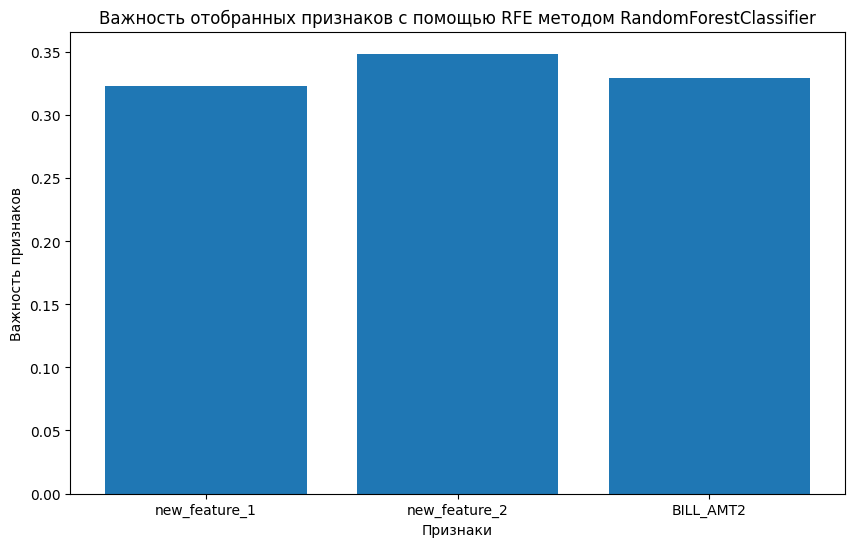

In [11]:
X = df_[['new_feature_1', 'new_feature_2', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']]
y = df_['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=model, n_features_to_select=3)  # Отбираем 3 признака
rfe.fit(X_train, y_train)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

model.fit(X_train_rfe, y_train)

selected_features = np.where(rfe.support_)[0]
print("Отобранные признаки (по индексу):", selected_features)
print("Имена отобранных признаков:", X.columns[selected_features])

plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features)), model.feature_importances_)
plt.xticks(range(len(selected_features)), X.columns[selected_features])
plt.ylabel("Важность признаков")
plt.xlabel("Признаки")
plt.title("Важность отобранных признаков с помощью RFE методом RandomForestClassifier")
plt.show()